In [14]:
import tensorflow as tf
from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np

from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output
from pathlib import Path

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
path_style = Path('/content/drive/MyDrive/nst/rain_princess.jpg')
path_content = Path('/content/drive/MyDrive/nst/stata.jpg')

In [17]:
def load_image(path_to_img):
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image

def load_images(content_path, style_path):
  content_image = load_image("{}".format(content_path))
  style_image = load_image("{}".format(style_path))

  return content_image, style_image

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

def display_images_with_titles(images, titles=[]):
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)

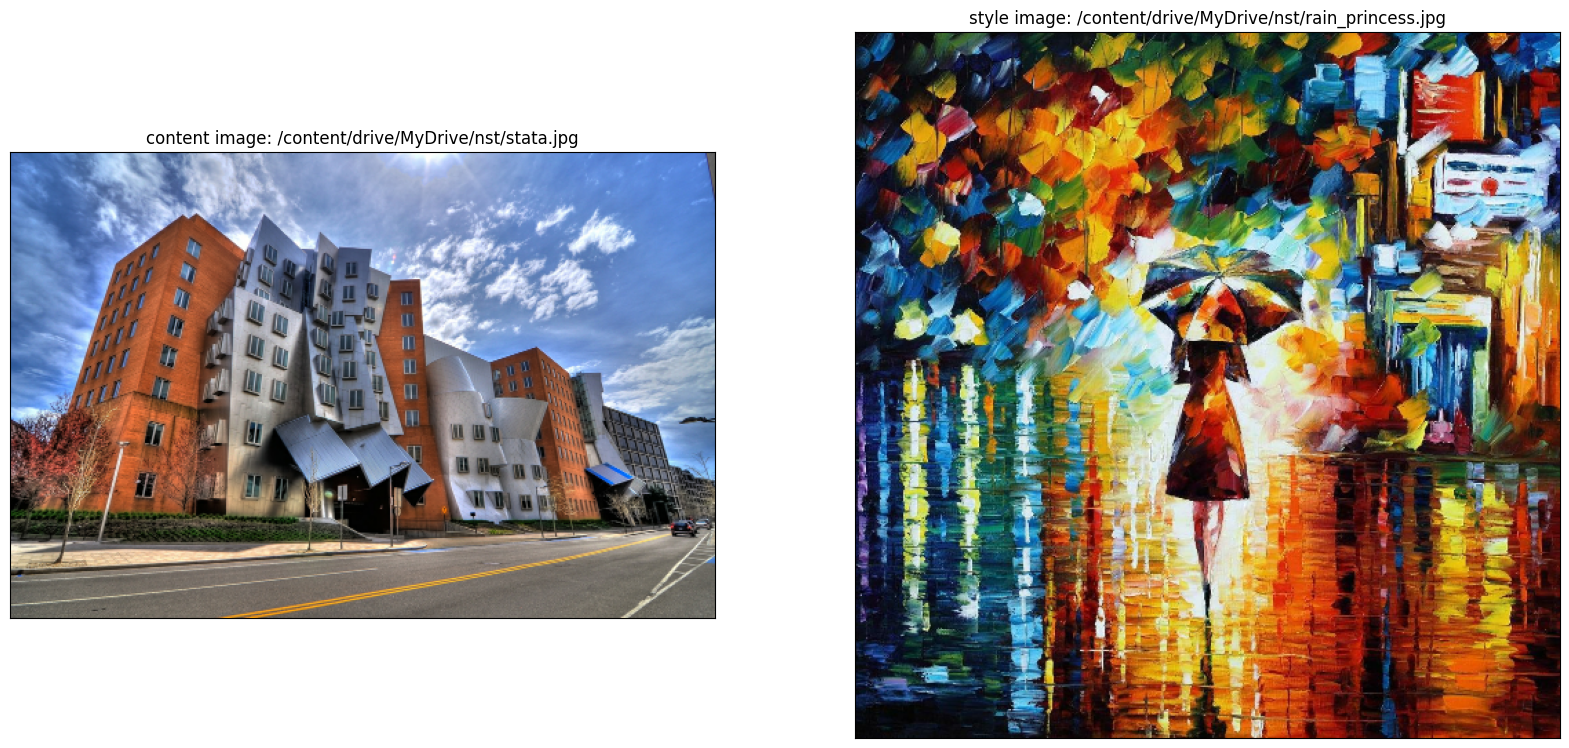

In [18]:
content_image, style_image = load_images(path_content, path_style)
display_images_with_titles([content_image, style_image],
                         titles=[f'content image: {path_content}',
                                 f'style image: {path_style}'])

In [19]:
content_layers = ['conv2d_93']

style_layers = ['conv2d',
                'conv2d_1',
                'conv2d_2',
                'conv2d_3',
                'conv2d_4']

all_layers = style_layers + content_layers

length_content_layers = len(content_layers)
length_style_layers = len(style_layers)


In [20]:
def create_inception_model(selected_layers):
    base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

    base_model.trainable = False

    layer_outputs = [base_model.get_layer(layer_name).output for layer_name in selected_layers]

    model = tf.keras.models.Model(inputs=base_model.input, outputs=layer_outputs)

    return model


In [21]:
K.clear_session()

inception = create_inception_model(all_layers)
inception

87910968/87910968 [==============================] - 0s 0us/step


In [22]:
def style_loss(activations, reference_activations):
    loss = tf.reduce_mean(tf.square(activations - reference_activations))

    return loss

In [23]:
def content_loss(activations, reference_activations):
    loss = 0.5 * tf.reduce_sum(tf.square(activations - reference_activations))

    return loss


In [24]:
def compute_gram_matrix(tensor):
    gram_matrix = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)

    shape = tf.shape(tensor)
    height = shape[1]
    width = shape[2]

    num_locations = tf.cast(height * width, tf.float32)
    scaled_gram_matrix = gram_matrix / num_locations

    return scaled_gram_matrix


In [25]:
tmp_layer_list = [layer.output for layer in inception.layers]
tmp_layer_list

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'batch_normalization')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'activation')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'batch_normalization_1')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'activation_1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'batch_normalization_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'activation_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32

In [26]:
def preprocess_image(image):
  image = tf.cast(image, dtype=tf.float32)
  image = (image / 127.5) - 1.0

  return image

In [27]:
def style_features(image):

  preprocessed_image = preprocess_image(image)

  outputs = inception(preprocessed_image)

  outputs = outputs[:length_style_layers]

  gram_features = [compute_gram_matrix(style_layer) for style_layer in outputs]

  return gram_features

In [28]:
def content_features(image):

  preprocessed_image = preprocess_image(image)

  outputs = inception(preprocessed_image)

  outputs = outputs[length_style_layers:]

  return outputs

In [29]:
def total_loss(style_targets, style_outputs, content_targets,
                           content_outputs, style_weight, content_weight):

  styleloss = tf.add_n([style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])

  contentloss = tf.add_n([content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])

  styleloss =  styleloss * style_weight / length_style_layers

  contentloss = contentloss * content_weight / length_content_layers

  total_loss = styleloss + contentloss

  return total_loss

In [30]:
def gradients(image, style_targets, content_targets,
                        style_weight, content_weight):

  with tf.GradientTape() as tape:

    style_feature = style_features(image)

    content_feature = content_features(image)

    loss =  total_loss(style_targets, style_feature, content_targets,
                                  content_feature, style_weight, content_weight)

  gradients = tape.gradient(loss, image)

  return gradients

In [31]:
def clip_image_values(image, min_value=0.0, max_value=255.0):
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)

In [32]:
def transfer_image_style(image, style_targets, content_targets, style_weight,
                            content_weight, optimizer):


  gradient = gradients(image, style_targets, content_targets,
                                  style_weight, content_weight)

  optimizer.apply_gradients([(gradient, image)])

  image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

In [33]:
def tensor_to_image(tensor):
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor)

In [34]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4,
                       optimizer='adam', epochs=1, steps_per_epoch=1):

  images = []
  step = 0

  style_targets = style_features(style_image)

  content_targets = content_features(content_image)

  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image)

  images.append(content_image)

  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1

      transfer_image_style(generated_image, style_targets, content_targets,
                              style_weight, content_weight, optimizer)

      print(".", end='')
      if (m + 1) % 10 == 0:
        images.append(generated_image)

    clear_output(wait=True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    images.append(generated_image)
    print("Train step: {}".format(step))

  generated_image = tf.cast(generated_image, dtype=tf.uint8)

  return generated_image, images

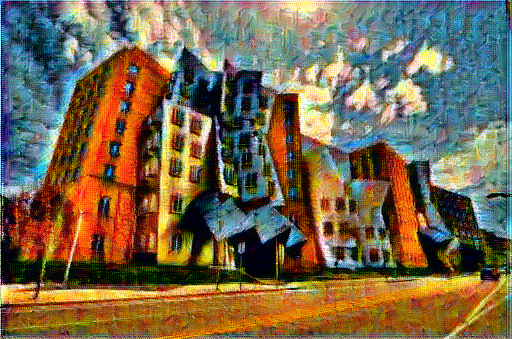

Train step: 1000


In [35]:

style_weight =  0.35
content_weight = 1e-32

adam = tf.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=80.0, decay_steps=100, decay_rate=0.80))

stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image,
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    optimizer=adam, epochs=10, steps_per_epoch=100)

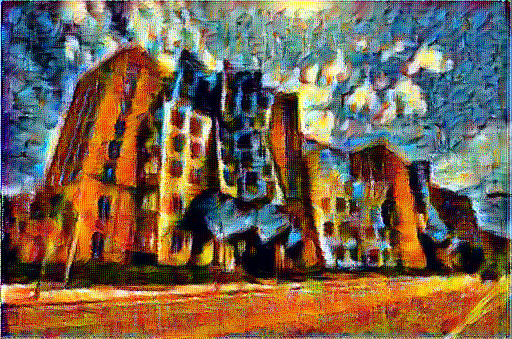

Train step: 1000


In [36]:

style_weight =  0.8
content_weight = 1e-32

adam = tf.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=80.0, decay_steps=100, decay_rate=0.80))

stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image,
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    optimizer=adam, epochs=10, steps_per_epoch=100)